In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
from tqdm import tqdm
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.manifold import TSNE
import seaborn as sns

In [ ]:
"""

walking = A
jogging = B
stairs = C
sitting = D
standing = E
typing = F
teeth = G
soup = H
chips = I
pasta = J
drinking = K
sandwich = L
kicking = M
catch = O
dribbling = P
writing = Q
clapping = R
folding = S

"""
ACTIVITY_MAP = {
    'A': 'walking',
    'B': 'jogging',
    'C': 'stairs',
    'D': 'sitting',
    'E': 'standing',
    'F': 'typing',
    'G': 'teeth',
    'H': 'soup',
    'I': 'chips',
    'J': 'pasta',
    'K': 'drinking',
    'L': 'sandwich',
    'M': 'kicking',
    'O': 'catch',
    'P': 'dribbling',
    'Q': 'writing',
    'R': 'clapping',
    'S': 'folding'
}

ACTIVITY_CODE = {
    'A': 0,
    'B': 1,
    'C': 2,
    'D': 3,
    'E': 4,
    'F': 5,
    'G': 6,
    'H': 7,
    'I': 8,
    'J': 9,
    'K': 10,
    'L': 11,
    'M': 12,
    'O': 13,
    'P': 14,
    'Q': 15,
    'R': 16,
    'S': 17
}

In [ ]:
def load_data(subject_id, device, sensor):
    filepath = f'../dataset/{device}_csv/{sensor}/data_{subject_id}_{sensor}_{device}.csv'
    df = pd.read_csv(filepath)
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ns')
    df['activity_code'] = df['activity_code'].map(ACTIVITY_CODE)
    return df

subject_1600_data = load_data('1600', 'phone', 'accel')

print(f"Total data shape for subject 1600: {subject_1600_data.shape}")

subject_1600_data.head()

In [ ]:
def split_df_into_segments(df, time_col='timestamp', threshold=pd.Timedelta('1s')):
    time_diffs = df[time_col].diff().fillna(pd.Timedelta(seconds=0))
    segment_ids = (abs(time_diffs) > threshold).cumsum()
    segments = [group.reset_index(drop=True) for _, group in df.groupby(segment_ids)]
    for segment in segments:
        segment['timestamp'] = (segment[time_col] - segment[time_col].min()).dt.total_seconds()

    return segments

segments = split_df_into_segments(subject_1600_data)

print(f"Total segments found: {len(segments)}")
print(segments[0].head())

for i, segment in enumerate(segments[:2]):
    print(f"Segment {i+1} shape: {segment.shape}")
    plt.figure(figsize=(10, 12))

    plt.subplot(3, 1, 1)
    plt.plot(segment['timestamp'], segment['x'], label='X-axis')

    plt.subplot(3, 1, 2)
    plt.plot(segment['timestamp'], segment['y'], label='Y-axis')

    plt.subplot(3, 1, 3)
    plt.plot(segment['timestamp'], segment['z'], label='Z-axis')

    plt.title(f'Segment {i+1}')
    plt.xlabel('Time')
    plt.ylabel('Acceleration')
    plt.legend()
    plt.show()


In [ ]:
def create_windowed_dataseries(segment, window_size=10, step_size=5):
    windows = []
    assert segment['activity_code'].nunique() == 1, "Segment contains multiple activities."
    for start in range(0, len(segment) - window_size + 1, step_size):
        window = segment.iloc[start:start + window_size].copy()
        xs = window['x'].values
        ys = window['y'].values
        zs = window['z'].values
        window_np = np.concatenate([xs, ys, zs], axis=0)
        window_df = pd.DataFrame([window_np], columns=[f'feat_{i}' for i in range(len(window_np))])
        activity_df = pd.DataFrame(np.zeros((1, len(ACTIVITY_CODE)), np.uint8), columns=[f'activity_{i}' for i in range(len(ACTIVITY_CODE))])
        activity_df[f'activity_{segment["activity_code"].iloc[0]}'] = 1
        window_df = pd.concat([window_df, activity_df], axis=1)
        windows.append(window_df)

    return pd.concat(windows, ignore_index=True)

windowed_data = create_windowed_dataseries(segments[0], window_size=10, step_size=5)
windowed_data.head()

In [ ]:
class HARDataset(Dataset):
    def __init__(self, subjects, device, sensor, window_size=10, step_size=5, shuffle=True):
        segments = []
        for subject_id in tqdm(subjects):
            df = load_data(subject_id, device, sensor)
            segments.extend(split_df_into_segments(df))

        if shuffle:
            np.random.shuffle(segments)

        windows = []
        for segment in tqdm(segments):
            windowed_segment = create_windowed_dataseries(segment, window_size, step_size)
            windows.append(windowed_segment)

        self.data = pd.concat(windows, ignore_index=True)
        self.length = len(self.data)

    def __len__(self):
        return self.length
    
    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        features = row.filter(like='feat_').values.astype(np.float32).reshape(3, -1)
        labels = row.filter(like='activity_').values.astype(np.float32)
        return features, labels


In [ ]:
subjects = [f'16{str(i).zfill(2)}' for i in range(0, 51)]
print(subjects)

dataset = HARDataset(subjects, device='phone', sensor='accel', window_size=20, step_size=10)

In [ ]:
torch.save(dataset, '../dataset/har_dataset_phone_accel.pt')
# dataset = torch.load('../dataset/har_dataset_phone_accel.pt', weights_only=False)

In [ ]:
# print("Loading dataset from file...")
# dataset = torch.load('dataset/har_dataset_phone_accel.pt')

train_dataset, test_dataset = train_test_split(dataset, test_size=0.2, random_state=42)
train_dataset, val_dataset = train_test_split(train_dataset, test_size=0.1, random_state=42)

train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True, pin_memory=True, pin_memory_device='cuda')
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False, pin_memory=True, pin_memory_device='cuda')
val_dataloader = DataLoader(val_dataset, batch_size=128, shuffle=False, pin_memory=True, pin_memory_device='cuda')

In [33]:
class HARCNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(HARCNN, self).__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv1d(in_channels=3, out_channels=64, kernel_size=11, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),

            nn.Conv1d(in_channels=64, out_channels=128, kernel_size=5, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),

            nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),

            nn.Flatten()
        )

        self.classifier = nn.Sequential(
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.classifier(x)
        return x


100%|██████████| 2696/2696 [00:13<00:00, 198.56it/s]


Epoch [1/500], Train Loss: 1.7246, Val Loss: 1.2904, Val Acc: 0.5437


100%|██████████| 2696/2696 [00:13<00:00, 198.48it/s]


Epoch [2/500], Train Loss: 1.2519, Val Loss: 1.0244, Val Acc: 0.6409


100%|██████████| 2696/2696 [00:13<00:00, 198.29it/s]


Epoch [3/500], Train Loss: 1.0902, Val Loss: 0.9366, Val Acc: 0.6698


100%|██████████| 2696/2696 [00:13<00:00, 198.90it/s]


Epoch [4/500], Train Loss: 1.0123, Val Loss: 0.8989, Val Acc: 0.6852


100%|██████████| 2696/2696 [00:13<00:00, 198.30it/s]


Epoch [5/500], Train Loss: 0.9644, Val Loss: 0.8631, Val Acc: 0.6964


100%|██████████| 2696/2696 [00:13<00:00, 198.38it/s]


Epoch [6/500], Train Loss: 0.9295, Val Loss: 0.8352, Val Acc: 0.7067


100%|██████████| 2696/2696 [00:13<00:00, 198.78it/s]


Epoch [7/500], Train Loss: 0.9037, Val Loss: 0.8063, Val Acc: 0.7215


100%|██████████| 2696/2696 [00:13<00:00, 198.19it/s]


Epoch [8/500], Train Loss: 0.8822, Val Loss: 0.8099, Val Acc: 0.7195


100%|██████████| 2696/2696 [00:13<00:00, 197.67it/s]


Epoch [9/500], Train Loss: 0.8636, Val Loss: 0.7924, Val Acc: 0.7263


100%|██████████| 2696/2696 [00:13<00:00, 198.80it/s]


Epoch [10/500], Train Loss: 0.8484, Val Loss: 0.7841, Val Acc: 0.7290


100%|██████████| 2696/2696 [00:13<00:00, 196.83it/s]


Epoch [11/500], Train Loss: 0.8364, Val Loss: 0.7940, Val Acc: 0.7303


100%|██████████| 2696/2696 [00:13<00:00, 198.79it/s]


Epoch [12/500], Train Loss: 0.8246, Val Loss: 0.7666, Val Acc: 0.7370


100%|██████████| 2696/2696 [00:13<00:00, 197.37it/s]


Epoch [13/500], Train Loss: 0.8127, Val Loss: 0.7900, Val Acc: 0.7305


100%|██████████| 2696/2696 [00:13<00:00, 198.74it/s]


Epoch [14/500], Train Loss: 0.8056, Val Loss: 0.7531, Val Acc: 0.7474


100%|██████████| 2696/2696 [00:13<00:00, 198.68it/s]


Epoch [15/500], Train Loss: 0.7983, Val Loss: 0.7668, Val Acc: 0.7432


100%|██████████| 2696/2696 [00:13<00:00, 198.95it/s]


Epoch [16/500], Train Loss: 0.7907, Val Loss: 0.7671, Val Acc: 0.7439


100%|██████████| 2696/2696 [00:13<00:00, 197.65it/s]


Epoch [17/500], Train Loss: 0.7819, Val Loss: 0.7721, Val Acc: 0.7416


100%|██████████| 2696/2696 [00:13<00:00, 198.66it/s]


Epoch [18/500], Train Loss: 0.7727, Val Loss: 0.7373, Val Acc: 0.7508


100%|██████████| 2696/2696 [00:13<00:00, 198.12it/s]


Epoch [19/500], Train Loss: 0.7688, Val Loss: 0.7386, Val Acc: 0.7542


100%|██████████| 2696/2696 [00:13<00:00, 198.96it/s]


Epoch [20/500], Train Loss: 0.7618, Val Loss: 0.7460, Val Acc: 0.7453


100%|██████████| 2696/2696 [00:13<00:00, 197.88it/s]


Epoch [21/500], Train Loss: 0.7557, Val Loss: 0.7441, Val Acc: 0.7515


100%|██████████| 2696/2696 [00:13<00:00, 198.53it/s]


Epoch [22/500], Train Loss: 0.7542, Val Loss: 0.7567, Val Acc: 0.7530


100%|██████████| 2696/2696 [00:13<00:00, 198.36it/s]


Epoch [23/500], Train Loss: 0.7497, Val Loss: 0.7675, Val Acc: 0.7450


100%|██████████| 2696/2696 [00:13<00:00, 198.55it/s]


Epoch [24/500], Train Loss: 0.7457, Val Loss: 0.7483, Val Acc: 0.7552


100%|██████████| 2696/2696 [00:13<00:00, 198.14it/s]


Epoch [25/500], Train Loss: 0.7429, Val Loss: 0.7576, Val Acc: 0.7518


100%|██████████| 2696/2696 [00:13<00:00, 196.53it/s]


Epoch [26/500], Train Loss: 0.7370, Val Loss: 0.7613, Val Acc: 0.7542


100%|██████████| 2696/2696 [00:13<00:00, 197.33it/s]


Epoch [27/500], Train Loss: 0.7349, Val Loss: 0.7485, Val Acc: 0.7522


100%|██████████| 2696/2696 [00:13<00:00, 197.06it/s]


Epoch [28/500], Train Loss: 0.7310, Val Loss: 0.7476, Val Acc: 0.7606


100%|██████████| 2696/2696 [00:13<00:00, 196.75it/s]


Epoch [29/500], Train Loss: 0.7312, Val Loss: 0.7470, Val Acc: 0.7595


100%|██████████| 2696/2696 [00:13<00:00, 203.31it/s]


Epoch [30/500], Train Loss: 0.7272, Val Loss: 0.7677, Val Acc: 0.7516


100%|██████████| 2696/2696 [00:10<00:00, 255.38it/s]


Epoch [31/500], Train Loss: 0.7217, Val Loss: 0.7412, Val Acc: 0.7581


100%|██████████| 2696/2696 [00:13<00:00, 197.59it/s]


Epoch [32/500], Train Loss: 0.7216, Val Loss: 0.7646, Val Acc: 0.7510


100%|██████████| 2696/2696 [00:13<00:00, 197.72it/s]


Epoch [33/500], Train Loss: 0.7194, Val Loss: 0.7656, Val Acc: 0.7559


100%|██████████| 2696/2696 [00:13<00:00, 196.14it/s]


Epoch [34/500], Train Loss: 0.7130, Val Loss: 0.7605, Val Acc: 0.7610


100%|██████████| 2696/2696 [00:13<00:00, 197.61it/s]


Epoch [35/500], Train Loss: 0.7165, Val Loss: 0.7455, Val Acc: 0.7620


100%|██████████| 2696/2696 [00:13<00:00, 197.80it/s]


Epoch [36/500], Train Loss: 0.7128, Val Loss: 0.7519, Val Acc: 0.7639


100%|██████████| 2696/2696 [00:13<00:00, 198.54it/s]


Epoch [37/500], Train Loss: 0.7066, Val Loss: 0.7940, Val Acc: 0.7521


100%|██████████| 2696/2696 [00:13<00:00, 197.36it/s]


Epoch [38/500], Train Loss: 0.7049, Val Loss: 0.7480, Val Acc: 0.7657
Early stopping triggered.


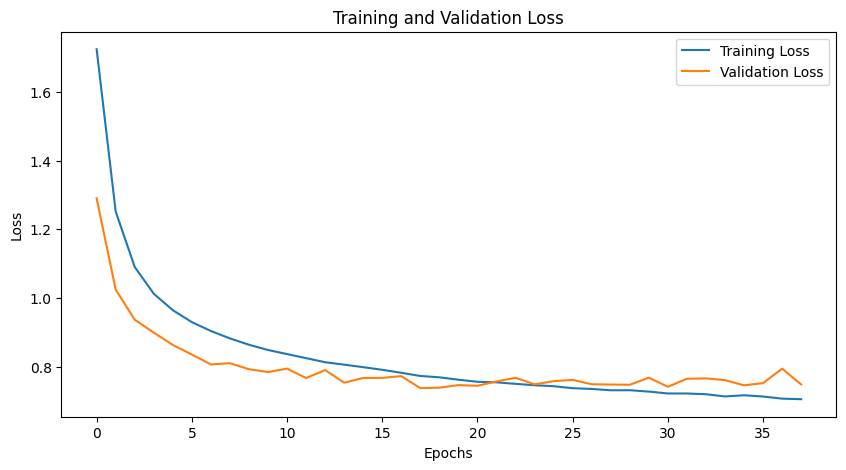

In [34]:
model = HARCNN(input_size=20, num_classes=len(ACTIVITY_CODE)).to('cuda')
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

training_loss = []
validation_loss = []
best_val_loss = float('inf')
best_model_state = None
epochs = 500
patience = 20
patience_counter = 0

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for features, labels in tqdm(train_dataloader):
        features = features.to('cuda')
        labels = labels.to('cuda')
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_dataloader)
    training_loss.append(avg_train_loss)

    model.eval()
    total_val_loss = 0
    total_val_accuracy = 0
    with torch.no_grad():
        for features, labels in val_dataloader:
            outputs = model(features.to('cuda'))
            loss = criterion(outputs, labels.to('cuda'))
            accuracy = (outputs.argmax(dim=1) == labels.argmax(dim=1).to('cuda')).float().mean()
            total_val_accuracy += accuracy.item()
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_dataloader)
    avg_val_accuracy = total_val_accuracy / len(val_dataloader)

    validation_loss.append(avg_val_loss)

    print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {avg_val_accuracy:.4f}')

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_state = model.state_dict()
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

torch.Size([128, 18]) torch.Size([128]) torch.Size([128])
torch.Size([128, 18]) torch.Size([128]) torch.Size([128])
torch.Size([128, 18]) torch.Size([128]) torch.Size([128])
torch.Size([128, 18]) torch.Size([128]) torch.Size([128])
torch.Size([128, 18]) torch.Size([128]) torch.Size([128])
torch.Size([128, 18]) torch.Size([128]) torch.Size([128])
torch.Size([128, 18]) torch.Size([128]) torch.Size([128])
torch.Size([128, 18]) torch.Size([128]) torch.Size([128])
torch.Size([128, 18]) torch.Size([128]) torch.Size([128])
torch.Size([128, 18]) torch.Size([128]) torch.Size([128])
torch.Size([128, 18]) torch.Size([128]) torch.Size([128])
torch.Size([128, 18]) torch.Size([128]) torch.Size([128])
torch.Size([128, 18]) torch.Size([128]) torch.Size([128])
torch.Size([128, 18]) torch.Size([128]) torch.Size([128])
torch.Size([128, 18]) torch.Size([128]) torch.Size([128])
torch.Size([128, 18]) torch.Size([128]) torch.Size([128])
torch.Size([128, 18]) torch.Size([128]) torch.Size([128])
torch.Size([12

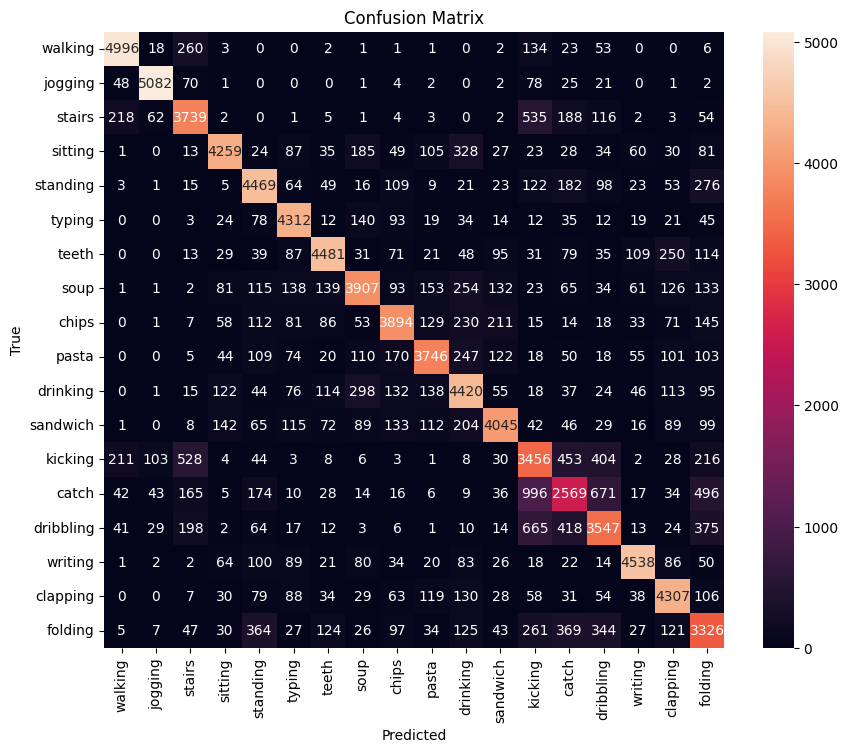

In [35]:
# Load the best model state
model.load_state_dict(best_model_state)

# Evaluate on test set
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for features, labels in test_dataloader:
        features = features.to('cuda')
        labels = torch.argmax(labels, dim=1).to('cuda')

        outputs = model(features)
        predicted = torch.argmax(outputs, dim=1)

        print(outputs.shape, predicted.shape, labels.shape)

        all_preds.append(predicted.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

all_labels = np.concat(all_labels, axis=0)
all_preds = np.concat(all_preds, axis=0)

print(classification_report(all_labels, all_preds, target_names=[ACTIVITY_MAP[key] for key in ACTIVITY_CODE.keys()]))
conf_mat = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=[ACTIVITY_MAP[key] for key in ACTIVITY_CODE.keys()], yticklabels=[ACTIVITY_MAP[key] for key in ACTIVITY_CODE.keys()])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()